Import Data:

In [1]:
import pandas as pd
import numpy as np
import datetime
pd.set_option('display.max_columns', 999)
import pandas.io.sql as psql
# plot a figure directly on Notebook
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack

[nltk_data] Downloading package punkt to /Users/vincent/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
admissions = pd.read_csv("data/ADMISSIONS.csv.gz", compression='gzip')
# diagnoses = pd.read_csv("data/DIAGNOSES_ICD.csv.gz", compression='gzip')
patients = pd.read_csv("data/PATIENTS.csv.gz", compression='gzip')
note_events = pd.read_csv("data/NOTEEVENTS.csv.gz", compression='gzip', low_memory=False)

# admissions = pd.read_csv("demo-data/ADMISSIONS.csv")
# diagnoses = pd.read_csv("demo-data/DIAGNOSES_ICD.csv")
# patients = pd.read_csv("demo-data/PATIENTS.csv")

print("Admissions Table\t" + str(admissions.shape))
print(admissions.columns)
# print("\nDiagnoses Table\t\t" + str(diagnoses.shape))
# print(diagnoses.columns)
print("\nPatients Table\t\t" + str(patients.shape))
print(patients.columns)
print("\nNote Events Table\t\t" + str(note_events.shape))
print(note_events.columns)

Admissions Table	(58976, 19)
Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

Patients Table		(46520, 8)
Index(['ROW_ID', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN',
       'EXPIRE_FLAG'],
      dtype='object')

Note Events Table		(2083180, 11)
Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME',
       'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT'],
      dtype='object')


In [3]:
# # Iterate through table
# # Regular Table: subect_id: the whole row that is their first admssion
# # During iteration, if subject_id is already in the newTableWeAreCreating, then we have seen the subject, we are doing a readmission right now
#     # But, we have to check the time frame, because if its 30 days after the dictionary value, this is a new set of admission to consider
# # first_admission_dataframe = pd.DataFrame(columns=admission_table.columns)
# first_admission_dataframe = pd.DataFrame(columns=admission_table.columns)

# # Iterate over rows
# for index, row in admission_table.iterrows():
#     # check if the subject_id has been admitted before
#     if row['subject_id'] not in first_admission_dataframe['subject_id'].values:
#         # Append the row to the new DataFrame
#         first_admission_dataframe = pd.concat([first_admission_dataframe, pd.DataFrame([row])], 
#                                               axis=0, ignore_index=True)

# print(first_admission_dataframe['admittime'])
# # # Reset the index of the new DataFrame
# # first_admission_dataframe.reset_index(drop=True, inplace=True)

In [4]:
# Merge Tables
# merged = admissions.merge(patients, on="SUBJECT_ID").merge(diagnoses, 
#             left_on=["SUBJECT_ID","HADM_ID"], right_on=["SUBJECT_ID","HADM_ID"])
merged = admissions

#
# PROBLEM: there are multiple entries now for one admission time, each entry represents a different diagnoses
    # Counts for diagnoses for one admittime range from 1 to 57
        # print(merged['ADMITTIME'].value_counts())
# Possible Fixes: merge them all together and make a new column that holds each diagnoses in an array

# Convert time to objects
merged["ADMITTIME"] = pd.to_datetime(merged["ADMITTIME"], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
merged["DISCHTIME"] = pd.to_datetime(merged["DISCHTIME"], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
merged["DEATHTIME"] = pd.to_datetime(merged["DISCHTIME"], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

merged = merged.sort_values(['SUBJECT_ID','ADMITTIME'])
merged = merged.reset_index(drop = True)

merged['NEXT_ADMITTIME'] = merged.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
# get the next admission type
merged['NEXT_ADMISSION_TYPE'] = merged.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [5]:
len(merged['NEXT_ADMITTIME'].unique())

12451

In [6]:
rows = merged.NEXT_ADMISSION_TYPE == 'ELECTIVE'
merged.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
merged.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN
len(merged['NEXT_ADMITTIME'].unique())

11048

In [7]:
merged = merged.sort_values(['SUBJECT_ID','ADMITTIME'])
merged[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = merged.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

In [8]:
merged['NEXT_ADMITTIME'].unique()

<DatetimeArray>
[                'NaT', '2135-05-09 14:11:00', '2135-01-30 20:50:00',
 '2157-10-18 19:34:00', '2191-02-23 05:23:00', '2131-05-12 19:49:00',
 '2119-01-04 18:12:00', '2157-12-02 00:45:00', '2174-01-04 22:21:00',
 '2196-04-14 04:02:00',
 ...
 '2191-08-03 19:11:00', '2191-12-23 01:03:00', '2133-08-01 19:20:00',
 '2125-11-01 00:00:00', '2197-06-16 03:01:00', '2197-07-03 02:24:00',
 '2182-07-03 19:50:00', '2201-05-15 13:12:00', '2157-01-05 17:27:00',
 '2157-02-16 17:31:00']
Length: 11048, dtype: datetime64[ns]

In [9]:
merged['DAYS_NEXT_ADMIT']=(merged.NEXT_ADMITTIME - merged.DISCHTIME).dt.total_seconds()/(24*60*60)
merged['DAYS_STAY'] = (merged.DISCHTIME - merged.ADMITTIME).dt.total_seconds()/(24*60*60)
merged

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT,DAYS_STAY
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,2138-07-21 15:48:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,NaN,NaN,3.863889
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,2101-10-31 13:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1,NaT,NaN,NaN,10.784722
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,2191-03-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,NaT,NaN,NaN,7.759028
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,2103-02-04 12:15:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,NaN,NaN,2.322222
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,2175-06-15 16:00:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1,NaT,NaN,NaN,16.364583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58972,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00,2181-02-12 17:05:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,ENGL,JEWISH,MARRIED,WHITE,2181-01-26 23:35:00,2181-01-27 04:18:00,FEVER,0,1,NaT,NaN,NaN,16.595833
58972,58973,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00,2185-01-05 12:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,DIVERTICULITIS/SDA,0,1,NaT,NaN,NaN,12.156250
58973,58974,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00,2144-07-28 17:56:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,2144-07-25 13:40:00,2144-07-25 18:50:00,RETROPERITONEAL HEMORRHAGE,0,1,NaT,NaN,NaN,2.995139
58974,58975,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00,2147-02-11 13:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,ABDOMINAL AORTIC ANEURYSM/SDA,0,1,NaT,NaN,NaN,3.218750


In [10]:
# For all 'CATEGORY' = 'Discharge summary':
    #'DESCRIPTION': ['Addendum', 'Report']        *Do we care if Addendum vs. Report? Addendum seems to have more information than initial Report but also some different info like Service:"" 
    #'CGID': NaN
    #'ISERROR': NaN
    
# could use all categories of notes by concatenating them if we wanted.

discharge_notes = note_events[note_events['CATEGORY']=='Discharge summary']
unique_discharge_notes = discharge_notes.groupby(['SUBJECT_ID','HADM_ID']).nth(-1).reset_index()
unique_discharge_notes.duplicated(['HADM_ID']).sum() == 0

True

In [11]:
merged = merged.merge(unique_discharge_notes[['SUBJECT_ID', 'HADM_ID', 'TEXT']], on=['SUBJECT_ID', 'HADM_ID'], how='left')
merged

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT,DAYS_STAY,TEXT
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,2138-07-21 15:48:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,NaN,NaN,3.863889,NaN
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,2101-10-31 13:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1,NaT,NaN,NaN,10.784722,Admission Date: [**2101-10-20**] Discharg...
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,2191-03-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,NaT,NaN,NaN,7.759028,Admission Date: [**2191-3-16**] Discharge...
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,2103-02-04 12:15:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,NaN,NaN,2.322222,NaN
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,2175-06-15 16:00:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1,NaT,NaN,NaN,16.364583,Admission Date: [**2175-5-30**] Dischar...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58972,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00,2181-02-12 17:05:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,ENGL,JEWISH,MARRIED,WHITE,2181-01-26 23:35:00,2181-01-27 04:18:00,FEVER,0,1,NaT,NaN,NaN,16.595833,Admission Date: [**2181-1-27**] ...
58972,58973,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00,2185-01-05 12:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,DIVERTICULITIS/SDA,0,1,NaT,NaN,NaN,12.156250,Admission Date: [**2184-12-24**] ...
58973,58974,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00,2144-07-28 17:56:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,2144-07-25 13:40:00,2144-07-25 18:50:00,RETROPERITONEAL HEMORRHAGE,0,1,NaT,NaN,NaN,2.995139,Admission Date: [**2144-7-25**] ...
58974,58975,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00,2147-02-11 13:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,ABDOMINAL AORTIC ANEURYSM/SDA,0,1,NaT,NaN,NaN,3.218750,Admission Date: [**2147-2-8**] D...


In [12]:
merged = merged.merge(patients[['SUBJECT_ID', 'DOB', 'GENDER']], on=['SUBJECT_ID'], how='left')

In [13]:
#Calculate age

merged['DOB'] = pd.to_datetime(merged["DOB"], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
merged['ADMITTIME'] = pd.to_datetime(merged['ADMITTIME'])
merged['DOB']
merged['AGE'] = ((merged['ADMITTIME'].values  - merged['DOB'].values).astype(int)/8.64e13//365).astype(int)

In [14]:
merged

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT,DAYS_STAY,TEXT,DOB,GENDER,AGE
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,2138-07-21 15:48:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,NaN,NaN,3.863889,NaN,2138-07-17,M,0
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,2101-10-31 13:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1,NaT,NaN,NaN,10.784722,Admission Date: [**2101-10-20**] Discharg...,2025-04-11,M,76
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,2191-03-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,NaT,NaN,NaN,7.759028,Admission Date: [**2191-3-16**] Discharge...,2143-05-12,F,47
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,2103-02-04 12:15:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,NaN,NaN,2.322222,NaN,2103-02-02,M,0
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,2175-06-15 16:00:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1,NaT,NaN,NaN,16.364583,Admission Date: [**2175-5-30**] Dischar...,2109-06-21,F,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58972,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00,2181-02-12 17:05:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,ENGL,JEWISH,MARRIED,WHITE,2181-01-26 23:35:00,2181-01-27 04:18:00,FEVER,0,1,NaT,NaN,NaN,16.595833,Admission Date: [**2181-1-27**] ...,2127-04-08,M,53
58972,58973,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00,2185-01-05 12:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,DIVERTICULITIS/SDA,0,1,NaT,NaN,NaN,12.156250,Admission Date: [**2184-12-24**] ...,2137-04-07,M,47
58973,58974,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00,2144-07-28 17:56:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,2144-07-25 13:40:00,2144-07-25 18:50:00,RETROPERITONEAL HEMORRHAGE,0,1,NaT,NaN,NaN,2.995139,Admission Date: [**2144-7-25**] ...,2078-10-17,F,65
58974,58975,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00,2147-02-11 13:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,ABDOMINAL AORTIC ANEURYSM/SDA,0,1,NaT,NaN,NaN,3.218750,Admission Date: [**2147-2-8**] D...,2058-05-29,F,88


In [15]:
#Calculate age
# merged['DOB'] = pd.to_datetime(merged["DOB"], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
# merged['date_of_admission'] = pd.to_datetime(merged['date_of_admission'])
# merged['DOB']
# merged['AGE'] = ((merged['date_of_admission']-merged['DOB']).dt.days) //365

In [16]:
print(merged.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/merged.groupby('ADMISSION_TYPE').size())
merged[merged['ADMISSION_TYPE'] != 'NEWBORN'].groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/merged.groupby('ADMISSION_TYPE').size()

ADMISSION_TYPE
ELECTIVE     0.048663
EMERGENCY    0.037983
NEWBORN      0.536691
URGENT       0.042665
dtype: float64


ADMISSION_TYPE
ELECTIVE     0.048663
EMERGENCY    0.037983
NEWBORN           NaN
URGENT       0.042665
dtype: float64

In [17]:
merged = merged[merged['ADMISSION_TYPE'] != 'NEWBORN']

In [18]:
merged['READMISSION'] = (merged.DAYS_NEXT_ADMIT < 30).astype('int')
merged['READMISSION'].value_counts()

/var/folders/7z/606rkpcx117_bvzcp3wx_rbw0000gn/T/ipykernel_35374/331978591.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['READMISSION'] = (merged.DAYS_NEXT_ADMIT < 30).astype('int')


READMISSION
0    48109
1     3004
Name: count, dtype: int64

In [19]:
merged['AGE'].value_counts()

AGE
-285    2237
 78     1134
 77     1121
 69     1106
 62     1088
        ... 
 15        8
-275       6
-276       5
 14        1
-274       1
Name: count, Length: 89, dtype: int64

In [20]:
len(merged)

51113

In [21]:
merged = merged.sample(n = len(merged), random_state = 42)
merged = merged.reset_index(drop = True)

# Save 30% of the data as validation and test data 
valid_and_test_data = merged.sample(frac=0.30,random_state=42)
test_data = valid_and_test_data.sample(frac = 0.5, random_state = 42)
valid_data = valid_and_test_data.drop(test_data.index)

# use the rest of the data as training data
train_data = merged.drop(valid_and_test_data.index)

print(merged.shape)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)
print(str(test_data.shape[0] + valid_data.shape[0] + train_data.shape[0]))

(51113, 28)
(7667, 28)
(7667, 28)
(35779, 28)
51113


In [22]:
# There are a much larger amount of 0 labels than 1 labels (see merged['READMISSION'] counts)
# To solve this class imbalance, we randomly sample from the majority class (0 labels) an amount of data points equal to the minority class

# Split data by label
pos_train = train_data.loc[train_data['READMISSION'] == 1]
neg_train = train_data.loc[train_data['READMISSION'] != 1]

# Randomly sample data
sample_neg_train = neg_train.sample(n = len(pos_train), random_state = 42)

# Recombine Data
train_data = pd.concat([pos_train, sample_neg_train], axis = 0)
train_data = train_data.sample(n = len(train_data), random_state = 42).reset_index(drop = True)

In [23]:
print(train_data.shape)
print(sample_neg_train.shape)
print(pos_train.shape)

(4184, 28)
(2092, 28)
(2092, 28)


NLP processing on 'TEXT' column for discharge summaries from NOTE EVENTS TABLE

In [24]:
# Clean the string representation for 'TEXT' columns

train_data['TEXT'] = train_data['TEXT'].fillna(' ').str.replace('\n',' ').replace('\r',' ')
test_data['TEXT'] = test_data['TEXT'].fillna(' ').str.replace('\n',' ').replace('\r',' ')
valid_data['TEXT'] = valid_data['TEXT'].fillna(' ').str.replace('\n',' ').replace('\r',' ')

In [25]:
# import string
# def tokenizer_better(text):
#     # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words
    
#     punc_list = string.punctuation+'0123456789'
#     t = str.maketrans(dict.fromkeys(punc_list, " "))
#     text = text.lower().translate(t)
#     tokens = nltk.word_tokenize(text)
#     return tokens

In [26]:
# Write tokenizer that removes non-words
tokenizeText = lambda x: nltk.tokenize.RegexpTokenizer(r'\b[a-zA-Z_]+\b').tokenize(x.lower())

sample_text = ['Data science is about the data', 'The science is amazing', 'Predictive modeling is part of data science']
vect = CountVectorizer(tokenizer = tokenizeText)
vect.fit(sample_text)
# matrix is stored as a sparse matrix (since you have a lot of zeros)
X = vect.transform(sample_text)
X.toarray()

/Users/vincent/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


array([[1, 0, 2, 1, 0, 0, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0]])

In [27]:
my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                 'from','there','an','that','p','are','have','has','h','but','o',
                 'namepattern','which','every','also', 'ml', 'mg', 'it', 'ni', 'm', 'if', 'should', 'currently', 'po', 'cc', 'md']

vect = CountVectorizer(max_features = 3000, tokenizer = tokenizeText, stop_words = my_stop_words)
# this could take a while
vect.fit(train_data['TEXT'].values)

CountVectorizer(max_features=3000,
                stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on',
                            'in', 'for', 'name', 'is', 'patient', 's', 'he',
                            'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am',
                            'were', 'you', 'pt', 'pm', 'by', 'be', 'had', ...],
                tokenizer=<function <lambda> at 0x4cbfa5760>)

In [28]:
X_train = vect.transform(train_data['TEXT'].values)
X_valid = vect.transform(valid_data['TEXT'].values)
X_test = vect.transform(test_data['TEXT'].values)

y_train = train_data['READMISSION']
y_valid = valid_data['READMISSION']
y_test = test_data['READMISSION']

In [29]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C = 0.0005, penalty = 'l2', random_state = 42)
clf.fit(X_train, y_train)

model = clf
y_train_preds = model.predict_proba(X_train)[:,1]
y_valid_preds = model.predict_proba(X_valid)[:,1]
y_test_preds = model.predict_proba(X_test)[:,1]

In [30]:
train_acc = np.mean(y_train == (y_train_preds > 0.5))
valid_acc = np.mean(y_valid == (y_valid_preds > 0.5))
test_acc = np.mean(y_test == (y_test_preds > 0.5))
print(train_acc)
print(valid_acc)
print(test_acc)

0.733508604206501
0.7058823529411765
0.7041867744880658


In [31]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, (y_test_preds > 0.5)))

0.6486521573678355


TRYING TO MAKE THE MODEL BETTER (UP UNTIL NOW IS JUST USING 'TEXT' COLUMN)

In [32]:
#** Trying with adding DAYS_STAY **

# Extract the 'DAYS_STAY' column and convert it to a sparse matrix
train_days_stay = train_data['DAYS_STAY'].values.reshape(-1, 1)
valid_days_stay = valid_data['DAYS_STAY'].values.reshape(-1, 1)
test_days_stay = test_data['DAYS_STAY'].values.reshape(-1, 1)


# Concatenate days_stay_column with X horizontally
X_train_with_days_stay = hstack((X_train, train_days_stay))
X_valid_with_days_stay = hstack((X_valid, valid_days_stay))
X_test_with_days_stay = hstack((X_test, test_days_stay))

clf2=LogisticRegression(C = 0.0005, penalty = 'l2', random_state = 42)
clf2.fit(X_train_with_days_stay, y_train)
model2 = clf2

y_train_with_days_stay_preds = model2.predict_proba(X_train_with_days_stay)[:,1]
y_valid_with_days_stay_preds = model2.predict_proba(X_valid_with_days_stay)[:,1]
y_test_with_days_stay_preds = model2.predict_proba(X_test_with_days_stay)[:,1]

train_with_daystay_acc = np.mean(y_train == (y_train_with_days_stay_preds > 0.5))
valid_with_daystay_acc = np.mean(y_valid == (y_valid_with_days_stay_preds > 0.5))
test_with_daystay_acc = np.mean(y_test == (y_test_with_days_stay_preds > 0.5))
print(train_with_daystay_acc)
print(valid_with_daystay_acc)
print(test_with_daystay_acc)
print("AUROC: ")
print(roc_auc_score(y_test, (y_test_with_days_stay_preds > 0.5)))

0.7358986615678776
0.7053606364940654
0.701447763140733
AUROC: 
0.6550570809671564


In [33]:
print(train_with_daystay_acc - train_acc)
print(valid_with_daystay_acc - valid_acc)
print(test_with_daystay_acc - test_acc)

0.002390057361376652
-0.0005217164471110758
-0.002739011347332787


USING patient data (age, gender)

In [34]:
#** Trying with adding GENDER **

# Extract the 'GENDER' column and convert it to a sparse matrix
train_gender_column = (train_data['GENDER']=='M').values.reshape(-1, 1)
valid_gender_column = (valid_data['GENDER']=='M').values.reshape(-1, 1)
test_gender_column = (test_data['GENDER']=='M').values.reshape(-1, 1)


# Concatenate days_stay_column with X horizontally (ADDING ON TO PREVIOUS DAYSTAY)
newX_train = hstack((X_train_with_days_stay, train_gender_column))
newX_valid = hstack((X_valid_with_days_stay, valid_gender_column))
newX_test = hstack((X_test_with_days_stay, test_gender_column))

clf3=LogisticRegression(C = 0.0005, penalty = 'l2', random_state = 42)
clf3.fit(newX_train, y_train)
model3 = clf3

newy_train = model3.predict_proba(newX_train)[:,1]
newy_valid = model3.predict_proba(newX_valid)[:,1]
newy_test = model3.predict_proba(newX_test)[:,1]

train_with_gender_acc = np.mean(y_train == (newy_train > 0.5))
valid_with_gender_acc = np.mean(y_valid == (newy_valid > 0.5))
test_with_gender_acc = np.mean(y_test == (newy_test > 0.5))
print(train_with_gender_acc)
print(valid_with_gender_acc)
print(test_with_gender_acc)
print("AUROC: ")
print(roc_auc_score(y_test, (newy_test > 0.5)))

0.7361376673040153
0.7054910656058432
0.7017086213642885
AUROC: 
0.6542130144605117


In [35]:
#** Trying with adding AGE **

# Extract the 'AGE' column and convert it to a sparse matrix
train_age_column = (train_data['AGE']).values.reshape(-1, 1)
valid_age_column = (valid_data['AGE']).values.reshape(-1, 1)
test_age_column = (test_data['AGE']).values.reshape(-1, 1)


# Concatenate days_stay_column with X horizontally (ADDING ON TO PREVIOUS DAYSTAY)
X_train_age = hstack((newX_train, train_age_column))
X_valid_age = hstack((newX_valid, valid_age_column))
X_test_age = hstack((newX_test, test_age_column))

clf3=LogisticRegression(C = 0.0005, penalty = 'l2', random_state = 42)
clf3.fit(X_train_age, y_train)
model3 = clf3

Y_train_age = model3.predict_proba(X_train_age)[:,1]
Y_valid_age = model3.predict_proba(X_valid_age)[:,1]
Y_test_age = model3.predict_proba(X_test_age)[:,1]

train_with_age_acc = np.mean(y_train == (Y_train_age > 0.5))
valid_with_age_acc = np.mean(y_valid == (Y_valid_age > 0.5))
test_with_age_acc = np.mean(y_test == (Y_test_age > 0.5))
print(train_with_age_acc)
print(valid_with_age_acc)
print(test_with_age_acc)
print("AUROC: ")
print(roc_auc_score(y_test, (Y_test_age > 0.5)))

0.7373326959847036
0.7011869049171775
0.700404330246511
AUROC: 
0.6554840173291961


/Users/vincent/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
# Try XGBoost

In [37]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(max_depth=3, n_estimators=1000).fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds =5, verbose = False)
train_xgb_pred = xgb_model.predict(X_train)
valid_xgb_pred = xgb_model.predict(X_valid)
test_xgb_pred = xgb_model.predict(X_test)

train_xgb_acc = np.mean(y_train == train_xgb_pred)
valid_xgb_acc = np.mean(y_valid == valid_xgb_pred)
test_xgb_acc = np.mean(y_test == test_xgb_pred)

auroc = roc_auc_score(y_test, test_xgb_pred)
        
print(train_xgb_acc)
print(valid_xgb_acc)
print(test_xgb_acc)
print("AUROC: ")
print(roc_auc_score(y_test, test_xgb_pred))

# Calculate the absolute errors
errors = abs(test_xgb_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error for X_test:', round(np.mean(errors), 2), 'degrees.')

/Users/vincent/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.744980879541109
0.6710577800965175
0.672362071214295
AUROC: 
0.6336550845969205
Mean Absolute Error for X_test: 0.33 degrees.


In [38]:
# Try Naive Bayes 

In [39]:
from sklearn.naive_bayes import GaussianNB

# Create and train the model
nb_model = GaussianNB().fit(X_train.toarray(), y_train)

# Predictions on training, validation, and test sets
train_nb_pred = nb_model.predict(X_train.toarray())
valid_nb_pred = nb_model.predict(X_valid.toarray())
test_nb_pred = nb_model.predict(X_test.toarray())

# Calculate accuracies
train_nb_acc = np.mean(y_train == train_nb_pred)
valid_nb_acc = np.mean(y_valid == valid_nb_pred)
test_nb_acc = np.mean(y_test == test_nb_pred)

# AUROC calculation
auroc_nb = roc_auc_score(y_test, test_nb_pred)

# Print results
print(train_nb_acc)
print(valid_nb_acc)
print(test_nb_acc)
print("AUROC: ")
print(auroc_nb)

# Calculate the absolute errors
errors = abs(test_nb_acc - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error for X_test:', round(np.mean(errors), 2), 'degrees.')

0.6613288718929254
0.7090126516238424
0.7036650580409547
AUROC: 
0.6031510157484925
Mean Absolute Error for X_test: 0.68 degrees.


In [40]:
def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

In [41]:
X_train_array = X_train.toarray()
X_valid_array = X_valid.toarray()
X_test_array = X_test.toarray()

In [42]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import roc_auc_score

# Design CNN architecture
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=X_train_array.shape[1], output_dim=100, input_length=X_train_array.shape[1]))
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
cnn_model.add(BatchNormalization())
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
cnn_model.fit(X_train_array, y_train, validation_data=(X_valid_array, y_valid), epochs=20, batch_size=64, callbacks=[early_stop])

# Evaluate CNN performance
train_cnn_acc = cnn_model.evaluate(X_train_array, y_train, verbose=0)[1]
valid_cnn_acc = cnn_model.evaluate(X_valid_array, y_valid, verbose=0)[1]
test_cnn_acc = cnn_model.evaluate(X_test_array, y_test, verbose=0)[1]

print(train_cnn_acc)
print(valid_cnn_acc)
print(test_cnn_acc)

# Predictions for test set
test_cnn_pred = cnn_model.predict(X_test_array)

# Calculate AUROC for CNN
auroc_cnn = roc_auc_score(y_test, test_cnn_pred)

# Print results
print("AUROC: ", auroc_cnn)

# Calculate the absolute errors
errors = abs(test_cnn_acc - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error for X_test:', round(np.mean(errors), 2), 'degrees.')


Epoch 1/20


/Users/vincent/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 509ms/step - accuracy: 0.5131 - loss: 4.1304 - val_accuracy: 0.9214 - val_loss: 2.6645
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 483ms/step - accuracy: 0.5265 - loss: 2.5552 - val_accuracy: 0.0929 - val_loss: 2.2299
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 485ms/step - accuracy: 0.5327 - loss: 2.1133 - val_accuracy: 0.0570 - val_loss: 1.8889
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 490ms/step - accuracy: 0.5437 - loss: 1.7518 - val_accuracy: 0.0570 - val_loss: 1.6357
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 34s 514ms/step - accuracy: 0.5417 - loss: 1.4771 - val_accuracy: 0.0571 - val_loss: 1.3712
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 485ms/step - accuracy: 0.5165 - loss: 1.2735 - val_accuracy: 0.3395 - val_loss: 1.1655
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 34s 523ms/step - accuracy: 0.5183 - loss: 1.1273 - val_accuracy: 0.6173 - val_loss: 1.0401
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 502ms/step - accuracy: 0.5196 - loss: 1.0079 - val_accuracy: 0.113

In [43]:
# Predictions for test set
y_test_preds = cnn_model.predict(X_test_array)
y_valid_preds = cnn_model.predict(X_valid_array)
y_train_preds = cnn_model.predict(X_train_array)


240/240 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step
240/240 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step


In [44]:
print(y_test_preds.shape)
print(y_valid_preds.shape)
print(y_train_preds.shape)
print(y_train.shape)

(7667, 1)
(7667, 1)
(4184, 1)
(4184,)


Train prevalence(n = 4184): 0.500
Valid prevalence(n = 7667): 0.057
Test prevalence(n = 7667): 0.062
Train AUC:0.475
Valid AUC:0.465
Test AUC:0.494
Train accuracy:0.487
Valid accuracy:0.880
Test accuracy:0.871
Train recall:0.039
Valid recall:0.041
Test recall:0.051
Train precision:0.372
Valid precision:0.035
Test precision:0.043
Train specificity:0.935
Valid specificity:0.931
Test specificity:0.925


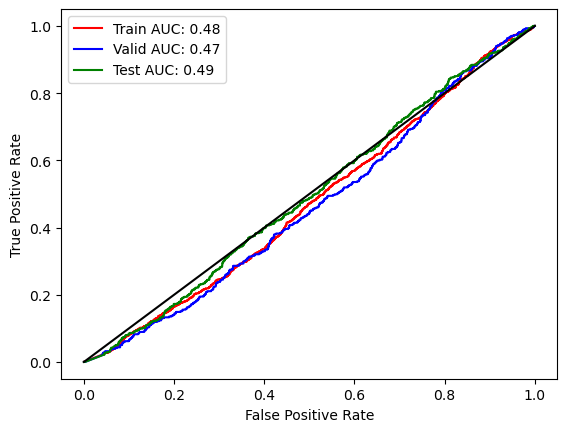

In [45]:
from sklearn.metrics import roc_curve
y_train = np.array(y_train).reshape(-1,1)
y_valid = np.array(y_valid).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
y_train_preds = np.array(y_train_preds).reshape(-1,1)
y_valid_preds = np.array(y_valid_preds).reshape(-1,1)
y_test_preds = np.array(y_test_preds).reshape(-1,1)


fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)

thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

print('Train prevalence(n = %d): %.3f'%(len(y_train),sum(y_train)/ len(y_train)))
print('Valid prevalence(n = %d): %.3f'%(len(y_valid),sum(y_valid)/ len(y_valid)))
print('Test prevalence(n = %d): %.3f'%(len(y_test),sum(y_test)/ len(y_test)))

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)
print('Test AUC:%.3f'%auc_test)


print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))
print('Test accuracy:%.3f'%calc_accuracy(y_test, y_test_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))
print('Test recall:%.3f'%calc_recall(y_test, y_test_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))
print('Test precision:%.3f'%calc_precision(y_test, y_test_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))
print('Test specificity:%.3f'%calc_specificity(y_test, y_test_preds, thresh))

plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot(fpr_test, tpr_test,'g-',label = 'Test AUC: %.2f'%auc_test)

plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()



In [46]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.callbacks import EarlyStopping

X_train_array = X_train.toarray()
X_valid_array = X_valid.toarray()
X_test_array = X_test.toarray()

# Design CNN architecture
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=X_train_array.shape[1], output_dim=100, input_length=X_train_array.shape[1]))
cnn_model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
cnn_model.fit(X_train_array, y_train, validation_data=(X_valid_array, y_valid), epochs=20, batch_size=64, callbacks=[early_stop])

# Evaluate CNN performance
train_cnn_acc = cnn_model.evaluate(X_train_array, y_train, verbose=0)[1]
valid_cnn_acc = cnn_model.evaluate(X_valid_array, y_valid, verbose=0)[1]
test_cnn_acc = cnn_model.evaluate(X_test_array, y_test, verbose=0)[1]

print(train_cnn_acc)
print(valid_cnn_acc)
print(test_cnn_acc)

# Predictions for test set
test_cnn_pred = cnn_model.predict(X_test_array)

# Calculate AUROC for CNN
auroc_cnn = roc_auc_score(y_test, test_cnn_pred)

# Print results
print(train_cnn_acc)
print(valid_cnn_acc)
print(test_cnn_acc)
print("AUROC: ")
print(auroc_cnn)

# Calculate the absolute errors
errors = abs(test_cnn_acc - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error for X_test:', round(np.mean(errors), 2), 'degrees.')

Epoch 1/20


/Users/vincent/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - accuracy: 0.4924 - loss: 0.6937 - val_accuracy: 0.9344 - val_loss: 0.6448
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.5238 - loss: 0.6916 - val_accuracy: 0.9382 - val_loss: 0.6237
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - accuracy: 0.5460 - loss: 0.6875 - val_accuracy: 0.4193 - val_loss: 0.7186
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.5499 - loss: 0.6854 - val_accuracy: 0.5132 - val_loss: 0.7037
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.5723 - loss: 0.6803 - val_accuracy: 0.5692 - val_loss: 0.6959
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
0.504063069820404
0.9381765723228455
0.9350463151931763
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
0.504063069820404
0.9381765723228455
0.9350463151931763
AUROC: 
0.58885355072888
Mean Absolute Error for X_test: 0.88 degrees.


In [47]:
# Predictions for test set
y_test_preds = cnn_model.predict(X_test_array)
y_valid_preds = cnn_model.predict(X_valid_array)
y_train_preds = cnn_model.predict(X_train_array)

240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


Train prevalence(n = 4184): 0.500
Valid prevalence(n = 7667): 0.057
Test prevalence(n = 7667): 0.062
Train AUC:0.609
Valid AUC:0.608
Test AUC:0.589
Train accuracy:0.504
Valid accuracy:0.938
Test accuracy:0.935
Train recall:0.014
Valid recall:0.009
Test recall:0.015
Train precision:0.698
Valid precision:0.089
Test precision:0.189
Train specificity:0.994
Valid specificity:0.994
Test specificity:0.996


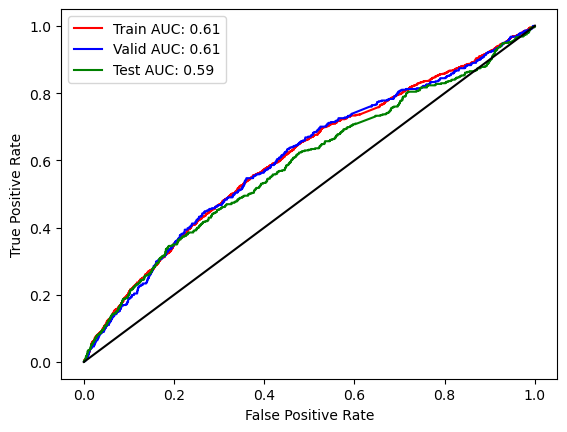

In [48]:
from sklearn.metrics import roc_curve
y_train = np.array(y_train).reshape(-1,1)
y_valid = np.array(y_valid).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
y_train_preds = np.array(y_train_preds).reshape(-1,1)
y_valid_preds = np.array(y_valid_preds).reshape(-1,1)
y_test_preds = np.array(y_test_preds).reshape(-1,1)

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)

thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

print('Train prevalence(n = %d): %.3f'%(len(y_train),sum(y_train)/ len(y_train)))
print('Valid prevalence(n = %d): %.3f'%(len(y_valid),sum(y_valid)/ len(y_valid)))
print('Test prevalence(n = %d): %.3f'%(len(y_test),sum(y_test)/ len(y_test)))

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)
print('Test AUC:%.3f'%auc_test)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))
print('Test accuracy:%.3f'%calc_accuracy(y_test, y_test_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))
print('Test recall:%.3f'%calc_recall(y_test, y_test_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))
print('Test precision:%.3f'%calc_precision(y_test, y_test_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))
print('Test specificity:%.3f'%calc_specificity(y_test, y_test_preds, thresh))

plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot(fpr_test, tpr_test,'g-',label = 'Test AUC: %.2f'%auc_test)

plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()



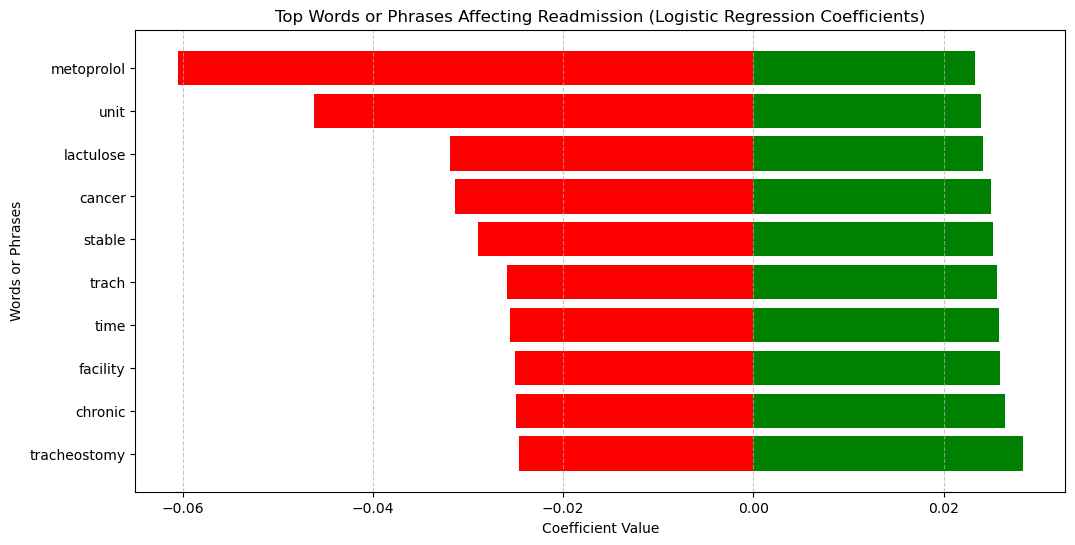

In [49]:
# Get the coefficients from the logistic regression model
coefficients = clf.coef_[0]

# Get feature names (words or phrases) from the CountVectorizer
feature_names = vect.get_feature_names_out()

# Create a dictionary mapping feature names to coefficients
feature_coefficient_dict = dict(zip(feature_names, coefficients))

# Sort the dictionary by coefficients
sorted_feature_coefficients = sorted(feature_coefficient_dict.items(), key=lambda x: x[1], reverse=True)

# Visualize top n words or phrases affecting readmission
n = 10  # Change this number to visualize more or fewer words
top_positive_words = sorted_feature_coefficients[:n]
top_negative_words = sorted_feature_coefficients[-n:]

# Plotting
plt.figure(figsize=(12, 6))
plt.barh(range(n), [coef for word, coef in top_positive_words], color='green', align='center')
plt.barh(range(n), [coef for word, coef in top_negative_words], color='red', align='center')
plt.yticks(range(n), [word for word, coef in top_positive_words])
plt.xlabel('Coefficient Value')
plt.ylabel('Words or Phrases')
plt.title('Top Words or Phrases Affecting Readmission (Logistic Regression Coefficients)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

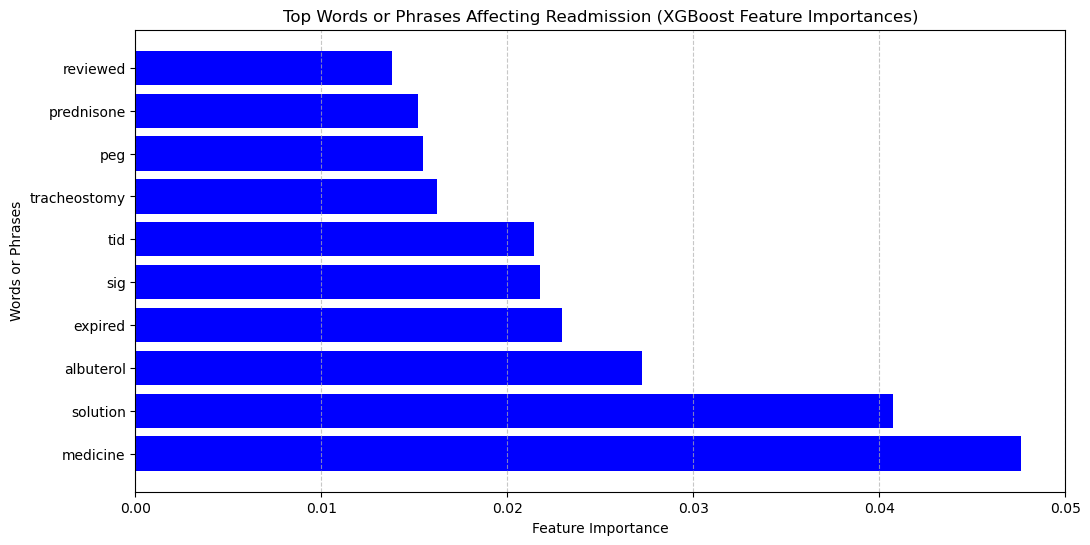

In [50]:
# Get feature importances from the trained XGBoost model
feature_importances = xgb_model.feature_importances_

# Create a dictionary mapping feature names (words or phrases) to feature importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the dictionary by feature importances
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Visualize top n words or phrases affecting readmission
n = 10  # Change this number to visualize more or fewer words
top_feature_importances = sorted_feature_importances[:n]

# Plotting
plt.figure(figsize=(12, 6))
plt.barh(range(n), [importance for word, importance in top_feature_importances], color='blue', align='center')
plt.yticks(range(n), [word for word, importance in top_feature_importances])
plt.xlabel('Feature Importance')
plt.ylabel('Words or Phrases')
plt.title('Top Words or Phrases Affecting Readmission (XGBoost Feature Importances)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [51]:
# import tensorflow as tf
# import transformers
# from transformers import BertTokenizer, TFBertForSequenceClassification
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [52]:
# # Define model hyperparameters
# MAX_LEN = 128
# BATCH_SIZE = 16
# LEARNING_RATE = 2e-5
# EPOCHS = 3

In [53]:
# # Initialize the tokenizer and model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# # model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
# print(TFBertForSequenceClassification.from_pretrained('bert-base-uncased'))

In [54]:
# # Compile the model
# optimizer = Adam(learning_rate=LEARNING_RATE)
# loss = SparseCategoricalCrossentropy(from_logits=True)
# model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [55]:
# # Tokenize and pad the input data
# train_inputs = tokenizer(train_data['TEXT'].tolist(), max_length=MAX_LEN, truncation=True, padding='max_length', return_tensors='tf')
# valid_inputs = tokenizer(valid_data['TEXT'].tolist(), max_length=MAX_LEN, truncation=True, padding='max_length', return_tensors='tf')
# test_inputs = tokenizer(test_data['TEXT'].tolist(), max_length=MAX_LEN, truncation=True, padding='max_length', return_tensors='tf')


In [56]:
# # Train the model
# history = model.fit(
#     x=train_inputs,
#     y=train_data['READMISSION'].values,
#     validation_data=(valid_inputs, valid_data['READMISSION'].values),
#     batch_size=BATCH_SIZE,
#     epochs=EPOCHS
# )

In [57]:
# # Evaluate the model on the test data
# test_loss, test_accuracy = model.evaluate(test_inputs, test_data['READMISSION'].values, batch_size=BATCH_SIZE)
# print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

In [58]:
# # Predictions
# predictions = model.predict(test_inputs)
# predicted_labels = tf.argmax(predictions.logits, axis=1).numpy()
# test_data['PREDICTED_READMISSION'] = predicted_labels
# print(test_data[['TEXT', 'READMISSION', 'PREDICTED_READMISSION']])

In [59]:
# # Predictions
# test_data['PREDICTED_READMISSION'] = predictions
# print(test_data[['TEXT', 'READMISSION', 'PREDICTED_READMISSION']])

In [60]:
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# from torch.utils.data import DataLoader, Dataset
# import torch

# # Define a custom dataset class
# class TextDataset(Dataset):
#     def __init__(self, texts, labels, tokenizer, max_len):
#         self.texts = texts
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.max_len = max_len

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, item):
#         text = str(self.texts[item])
#         label = self.labels[item]

#         encoding = self.tokenizer.encode_plus(
#             text,
#             add_special_tokens=True,
#             max_length=self.max_len,
#             return_token_type_ids=False,
#             padding='max_length',
#             return_attention_mask=True,
#             return_tensors='pt',
#             truncation=True
#         )

#         return {
#             'text': text,
#             'input_ids': encoding['input_ids'].flatten(),
#             'attention_mask': encoding['attention_mask'].flatten(),
#             'label': torch.tensor(label, dtype=torch.long)
#         }

# # Define model hyperparameters
# MAX_LEN = 128
# BATCH_SIZE = 16
# LEARNING_RATE = 2e-5
# EPOCHS = 3

# # Initialize the tokenizer and model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# # Set the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Create datasets and data loaders
# train_dataset = TextDataset(train_data['TEXT'], train_data['READMISSION'], tokenizer, MAX_LEN)
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# valid_dataset = TextDataset(valid_data['TEXT'], valid_data['READMISSION'], tokenizer, MAX_LEN)
# valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# test_dataset = TextDataset(test_data['TEXT'], test_data['READMISSION'], tokenizer, MAX_LEN)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# # Define optimizer and loss function
# optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
# criterion = torch.nn.CrossEntropyLoss()

# # Training loop
# for epoch in range(EPOCHS):
#     model.train()
#     for batch in train_loader:
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['label'].to(device)

#         optimizer.zero_grad()
#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         loss.backward()
#         optimizer.step()

#     # Validation loop
#     model.eval()
#     with torch.no_grad():
#         val_loss = 0.0
#         correct = 0
#         total = 0
#         for batch in valid_loader:
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             labels = batch['label'].to(device)

#             outputs = model(input_ids, attention_mask=attention_mask)
#             loss = criterion(outputs.logits, labels)
#             val_loss += loss.item()

#             _, predicted = torch.max(outputs.logits, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#         val_loss /= len(valid_loader)
#         accuracy = correct / total

#         print(f'Epoch {epoch+1}/{EPOCHS}, Validation Loss: {val_loss}, Accuracy: {accuracy}')

# # Evaluation on test data
# model.eval()
# with torch.no_grad():
#     test_loss = 0.0
#     correct = 0
#     total = 0
#     predictions = []
#     for batch in test_loader:
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['label'].to(device)

#         outputs = model(input_ids, attention_mask=attention_mask)
#         loss = criterion(outputs.logits, labels)
#         test_loss += loss.item()

#         _, predicted = torch.max(outputs.logits, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#         predictions.extend(predicted.cpu().numpy())

#     test_loss /= len(test_loader)
#     accuracy = correct / total

#     print(f'Test Loss: {test_loss}, Accuracy: {accuracy}')

# # Predictions
# test_data['PREDICTED_READMISSION'] = predictions
# print(test_data[['TEXT', 'READMISSION', 'PREDICTED_READMISSION']])


### 